In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertConfig,get_linear_schedule_with_warmup,AutoModelWithLMHead,BertForSequenceClassification
import torch
import torch.nn as nn 
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
import unicodedata
import spacy
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('punkt')
import random
import os
import time
import datetime

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natedrake7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/natedrake7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Pre-Processing

In [15]:
#Read csv files
train_set = pd.read_csv('./Data/train_set.csv')
valid_set = pd.read_csv('./Data/valid_set.csv')
test_set = pd.read_csv('./Data/test_set.csv')



#Drop Party and New ID columns since we dont need them
labels_to_drop = ['Party','New_ID']
train_set = train_set.drop(columns=labels_to_drop)
valid_set = valid_set.drop(columns=labels_to_drop)
test_set = test_set.drop(columns=['Party'])

train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'#', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'#', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'#', '', x))

#Remove accents from all text
def strip_accents_and_lowercase(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()

train_set['Text'] = train_set['Text'].apply(strip_accents_and_lowercase)
valid_set['Text'] = valid_set['Text'].apply(strip_accents_and_lowercase)
test_set['Text'] = test_set['Text'].apply(strip_accents_and_lowercase)

#Remove stopwords and replace them with a single space
stop = stopwords.words('greek')
pat = r'\b(?:{})\b'.format('|'.join(stop))

train_set['Text'] = train_set['Text'].str.replace(pat,'',regex=True)
valid_set['Text'] = valid_set['Text'].str.replace(pat,'',regex=True)
test_set['Text'] = test_set['Text'].str.replace(pat,'',regex=True)

#Remove multiple white spaces and replace them with a single space
train_set['Text'] = train_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
valid_set['Text'] = valid_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
test_set['Text'] = test_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces

#Remove links and replace them with a single space
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links

#Replace non greek words with single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))

#Find retweets and replace them withn single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))

#Load lemmatizer
nlp = spacy.load("el_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

#Lemmatize text to replace words with their dictionary value
train_set['Text'] = train_set['Text'].apply(lemmatize_text)
valid_set['Text'] = valid_set['Text'].apply(lemmatize_text)
test_set['Text'] = test_set['Text'].apply(lemmatize_text)

Save To CSV

In [16]:
train_set.to_csv('processed_df',index=False)
valid_set.to_csv('processed_valid',index=False)
test_set.to_csv('processed_test',index=False)

Read Pre-Processed Data

In [2]:
train_set = pd.read_csv('processed_df')

test_set = pd.read_csv('processed_test')

valid_set = pd.read_csv('processed_valid')

Wordcloud

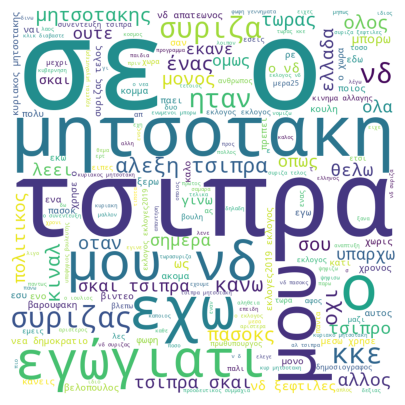

In [18]:
wordcloud = WordCloud(width=800, height=800,background_color='white').generate(' '.join(train_set['Text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Token Frequency

In [21]:
tokens = ' '.join(train_set['Text']).split()
token_counts = Counter(tokens)
print(token_counts.most_common(10))

[('ο', 18186), ('τσιπρα', 9896), ('μου', 8186), ('νδ', 8168), ('μητσοτακη', 6880), ('σε', 4528), ('εκλογος', 4298), ('εχω', 4205), ('συριζα', 3949), ('συριζας', 3630)]


Text Length Distribution

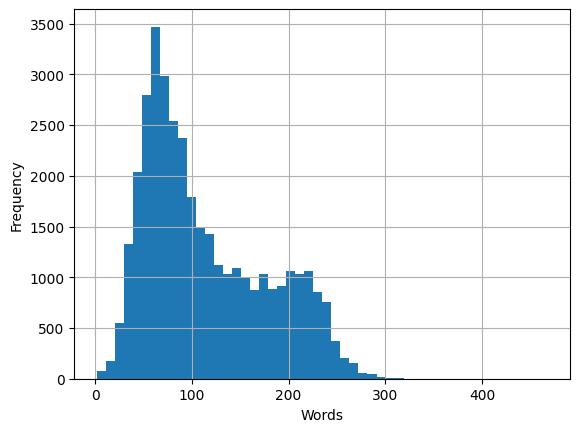

In [22]:
df = train_set.copy()

df['Text'] = df['Text'].apply(len)
df['Text'].hist(bins=50)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

Encode Labels

In [3]:
encoder  = LabelEncoder() #initialize label encoder so we can set integer values to the label unique values

X_train_labels = encoder.fit_transform(train_set['Sentiment']) #Transform the labels
X_valid_labels = encoder.fit_transform(valid_set['Sentiment']) #For both training and validation

print(encoder.classes_)
print(encoder.transform(encoder.classes_))
labels = {0 : 'NEGATIVE',1 : 'NEUTRAL',2 : 'POSITIVE'}

['NEGATIVE' 'NEUTRAL' 'POSITIVE']
[0 1 2]


Import BERT tokenizer

In [4]:
tokenizer = BertTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1", do_lower_case=True)

Find the maximun length of a sentence in all 3 Datasets

In [5]:
max_length = 0

for i,row in enumerate(train_set['Text']):
    train_row_length = len(tokenizer.encode(row, add_special_tokens=True))
    if i < len(test_set):
        test_row_length = len(tokenizer.encode(test_set['Text'][i], add_special_tokens=True))
    if i < len(valid_set):
        valid_row_length = len(tokenizer.encode(valid_set['Text'][i], add_special_tokens=True))
    # Update max_length if the current row's length is greater
    if train_row_length > max_length:
        max_length = train_row_length
    if test_row_length > max_length:
        max_length = test_row_length
    if valid_row_length > max_length:
        max_length = valid_row_length

print(max_length)

91


Tokenize Text

In [6]:
def TokenizeText(data):
    input_ids = []
    attention_masks = []
    for text in data:
        encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_length,  
                        padding= 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    return input_ids,attention_masks

train_input_ids,train_attention_masks = TokenizeText(train_set['Text'])
valid_input_ids,valid_attention_masks = TokenizeText(valid_set['Text'])
test_input_ids,test_attention_masks = TokenizeText(test_set['Text'])

Create Tensors

In [7]:
def CreateTensors(input_ids,attentions_masks,labels = None):
    if labels is None:
        return torch.cat(input_ids, dim=0),torch.cat(attentions_masks, dim=0)
    return torch.cat(input_ids, dim=0),torch.cat(attentions_masks, dim=0),torch.tensor(labels)

train_input_ids,train_attention_masks,train_labels = CreateTensors(train_input_ids,train_attention_masks,X_train_labels)
valid_input_ids,valid_attention_masks,valid_labels = CreateTensors(valid_input_ids,valid_attention_masks,X_valid_labels)
test_input_ids,test_attention_masks = CreateTensors(test_input_ids,test_attention_masks)

Create Tensor Datasets

In [8]:
batch_size = 128

train_dataset = TensorDataset(train_input_ids,train_attention_masks,train_labels)
train_dataloader = DataLoader(train_dataset,batch_size = batch_size)

valid_dataset = TensorDataset(valid_input_ids,valid_attention_masks,valid_labels)
valid_dataloader = DataLoader(valid_dataset,batch_size = batch_size)

test_dataset = TensorDataset(test_input_ids,test_attention_masks)
test_dataloader = DataLoader(test_dataset,batch_size = batch_size)

Set Device

In [9]:
if torch.cuda.is_available(): #if nvidia gpu is available
   device="cuda" #set devide to cuda since GPUs are much faster at deep learning
else: 
   device="cpu" #else set CPU
print("Device =",device)

Device = cuda


In [10]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [11]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
def LearningCurve(training_data,validation_data,plot_label='accuracy',y_label = 'accuracy'):
    epochs = range(1, len(training_data) + 1)
    plt.plot(epochs,training_data, label='Training ' + plot_label)
    plt.plot(epochs,validation_data, label='Validation ' + plot_label)

    plt.xlabel('Epoch')
    plt.ylabel(y_label)

    plt.legend()

    plt.title('Learning Curve')
    
    plt.show()   

In [12]:
def Train(model,dataloader,optimizer,scheduler):
    loss = 0
    total_loss = 0
    total_accuracy = 0

    # Measure how long the training epoch takes.
    t0 = time.time()
    for step,batch in enumerate(dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        loss, logits = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=False)
        
        total_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_accuracy += flat_accuracy(logits, label_ids)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)
    training_time = format_time(time.time() - t0)
    
    print("Average training loss: {0:.2f}".format(avg_loss))
    print("Accuracy: {0:.2f}".format(avg_accuracy))
    print("Training epoch took: {:}".format(training_time))
    
    return avg_accuracy,avg_loss,training_time

In [13]:
def Validate(model,dataloader):
    t0 = time.time()
    total_eval_accuracy = 0
    total_eval_loss = 0
    
    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            (loss, logits) = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=False)
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(dataloader)

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(dataloader)
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  Validation took: {:}".format(validation_time))

    return avg_val_accuracy,avg_val_loss,validation_time


In [14]:
model = BertForSequenceClassification.from_pretrained(
    "nlpaueb/bert-base-greek-uncased-v1",
    num_labels = 3,  
    output_attentions = False,
    output_hidden_states = False,
).to(device)

/home/natedrake7/.local/lib/python3.10/site-packages/torch/_utils.py:835: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
EPOCHS = 4

optimizer = torch.optim.AdamW(model.parameters(),lr = 2e-5,eps = 1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = len(train_dataloader) * EPOCHS)
training_stats = []

for epoch in range(0,EPOCHS):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, EPOCHS))
    print('Training...')
    t0 = time.time()

    model.train()

    avg_train_accuracy,avg_train_loss,training_time = Train(model,train_dataloader,optimizer,scheduler)

    model.eval()

    avg_val_accuracy,avg_val_loss,validation_time = Validate(model,valid_dataloader)

    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Accuracy': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Validation Accuracy.': avg_val_accuracy,
            'Validation. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-t0)))
    


======== Epoch 1 / 4 ========
Training...
Average training loss: 1.10
Accuracy: 0.36
Training epoch took: 0:04:21
  Accuracy: 0.40
  Validation Loss: 1.08
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
Average training loss: 1.08
Accuracy: 0.40
Training epoch took: 0:04:54
  Accuracy: 0.41
  Validation Loss: 1.06
  Validation took: 0:00:07

======== Epoch 3 / 4 ========
Training...
Average training loss: 1.05
Accuracy: 0.42
Training epoch took: 0:05:01
  Accuracy: 0.40
  Validation Loss: 1.06
  Validation took: 0:00:07

======== Epoch 4 / 4 ========
Training...
Average training loss: 1.03
Accuracy: 0.44
Training epoch took: 0:05:16
  Accuracy: 0.41
  Validation Loss: 1.06
  Validation took: 0:00:07

Training complete!
Total training took 0:05:23 (h:mm:ss)


Show Stats

In [21]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
df_stats = df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Accuracy,Training Loss,Validation Accuracy.,Validation. Loss,Training Time,Validation Time
epoch,,,,,,
1,0.362520,1.101163,0.396723,1.076741,0:04:21,0:00:07
2,0.397480,1.075215,0.409163,1.062458,0:04:54,0:00:07
3,0.419633,1.052518,0.401160,1.063774,0:05:01,0:00:07
4,0.444590,1.033098,0.414280,1.062631,0:05:16,0:00:07


Learning Curves

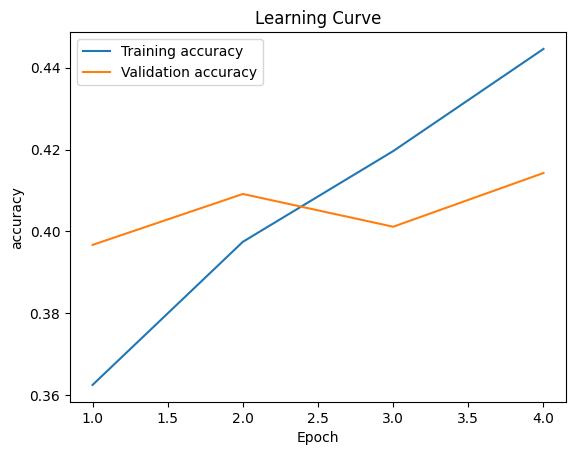

In [31]:
train_accuracy = []
valid_accuracy = []

train_loss = []
valid_loss = []

for stats in training_stats:
    train_accuracy.append(stats['Training Accuracy'])
    valid_accuracy.append(stats['Validation Accuracy.'])
    train_loss.append(stats['Training Loss'])
    valid_loss.append(stats['Validation. Loss'])

LearningCurve(train_accuracy,valid_accuracy)

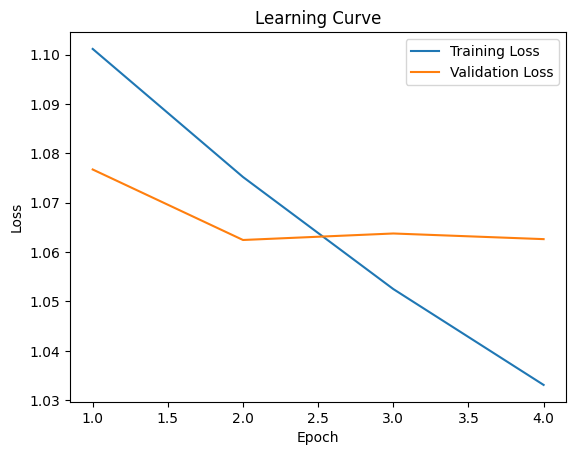

In [32]:
LearningCurve(train_loss,valid_loss,plot_label='Loss',y_label='Loss')